# Frame Classification
This Jupyter Notebook will deal with frame classification, the methods are adopted from Odijk et al. (2013).
NOTE: since training and classifying takes time, I will not rerun those relevant code blocks.

In [1]:
# ! pip install spacy
# !python -m spacy download en_core_web_trf

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multioutput import ClassifierChain


from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

import nltk
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from gensim.models import Word2Vec
from gensim.parsing.preprocessing import preprocess_string

import spacy
from spacy.tokens import DocBin
import en_core_web_trf
import matplotlib.pyplot as plt
import seaborn as sns
import os



## Data Cleaning

Load the data. The labeled.csv is the manually-labeled data file.

In [3]:
# Load the data
data = pd.read_csv('labeled.csv')

Split data into training and testing sets

In [4]:
X = data['Description']
y = data[['Conflict', 'Economic Consequences', 'Human Interest', 'Morality']]

Split into train-validation-test datasets.

In [5]:
# Split your data into training and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split your training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"We have {len(X_train)} train examples, {len(X_val)} validation examples, and {len(X_test)} test examples.")

We have 150 train examples, 50 validation examples, and 50 test examples.


Save the data for the separate BERT notebook.

In [6]:
X_train_val.to_csv('X_train_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train_val.to_csv('y_train_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)


# Baseline models

## 1. Stratified Random Classification Baseline
"Our first baseline approach is very naive and intended as a lower bound. It randomly choses the answer to a indicator question or whether a frame is present or not, taking into account only the prevalence in training set. This naive baseline randomly assigns a classification, without considering the document and its representation, with a probability based on the class distributions. This naive baseline will be more likely to randomly pick the majority class than the minority class." (Odijk et al., 2013)

Here, the values of the predictions are completely random. The np.random() is used. Documentation can be found in the numpy package for random sampling https://numpy.org/doc/stable/reference/random/index.html

In [7]:
# Calculate class distribution for each label
class_distribution = y_train.mean().values

# Generate random predictions based on class distribution
random_predictions = np.array([np.random.choice([0, 1], size=len(X_val), p=[1-cd, cd]) for cd in class_distribution]).T

Calculate the accuracy, precision, recall, f1 scores and report them.

In [8]:
# Evaluate Random Classifier
random_accuracy = [accuracy_score(y_val.iloc[:, i], random_predictions[:, i]) for i in range(y_val.shape[1])]
random_f1 = [f1_score(y_val.iloc[:, i], random_predictions[:, i], zero_division=0) for i in range(y_val.shape[1])]

In [9]:
# Prepare to display the results
frame_labels = y_val.columns.tolist()
evaluation_results = pd.DataFrame({
    'Frame': frame_labels,
    'Random Accuracy': random_accuracy,
    'Random F1 Score': random_f1,
})

evaluation_results

,Frame,Random Accuracy,Random F1 Score
0,Conflict,0.60,0.333333
1,Economic Consequences,0.54,0.303030
2,Human Interest,0.52,0.636364
3,Morality,0.56,0.421053


The random classification model shows a baseline of random guessing. It serves as a baseline comparison with the following classification approaches.

## 2. Direct Classification Baseline
Our second baseline approach is to classify answers to indicator questions and the presence of each frame directly. More formally, we train a classifier to estimate P(um|d) for each frame um ∈ U. This approach is the simplest approach and is depicted in Figure 1a. Note that for frames, we completely ignore the indicator questions in this baseline approach. For classification we use Logistic Regression to optimize logistic loss using Pegasos-style regularization. For training we alternate between pairwise ROCoptimization and standard stochastic gradient steps on single examples. This baseline approach aims to be flexible in dealing with issues such as class imbalance.

### 2.1 Define a function that trains, tunes and cross-validate the model.
The function can be found reference in my second take-home exam. The difference is that the take-home exam is a binary classification, but here the function uses multi-label classification. The change of the function can be explicitly found in the pipeline, where the classifier is MultiOutputClassifier(). The MultiOutputClassifier() is used for Multi target classification. This strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification. Documentation can be found in https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html.



In [10]:
def train_and_tune_model(title, X_train, y_train, X_val, y_val, target_names, model, vectorizer, param_grid, cv=10):
    # Create the pipeline with the vectorizer and the classifier wrapped in MultiOutputClassifier
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', MultiOutputClassifier(model))
    ])

    # Setup Grid Search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=1, scoring='accuracy', n_jobs=1, error_score='raise')

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Predict on the validation data using the best estimator
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_val)

    # Ensure y_val is a numpy array for indexing
    y_val_np = y_val.values

    # Generate and print the classification report
    reports = []
    roc_aucs = []
    for i, name in enumerate(target_names):
        report = classification_report(y_val_np[:, i], predictions[:, i], target_names=[f'Not {name}', name])
        reports.append(report)
        
        # Correctly access individual fitted model for each label to calculate ROC AUC
        if hasattr(best_model.named_steps['classifier'].estimators_[i], "predict_proba"):
            prob_predictions = best_model.named_steps['classifier'].estimators_[i].predict_proba(best_model.named_steps['vectorizer'].transform(X_val))[:, 1]
            roc_auc = roc_auc_score(y_val_np[:, i], prob_predictions)
            roc_aucs.append(roc_auc)
        else:
            roc_aucs.append(None)
    
    # Perform cross-validation on the complete training dataset using the best estimator
    cv_scores = cross_val_score(clone(best_model), X_train, y_train, cv=cv, scoring='accuracy')

    # Print the results including the title
    print(f"Best Parameters: {best_params}\nBest Score: {best_score}\n{title}:")
    for report, roc_auc, name in zip(reports, roc_aucs, target_names):
        print(f"\nClassification Report for {name}:\n{report}")
        if roc_auc is not None:
            print(f"ROC AUC for {name}: {roc_auc}\n")
    print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))

    return best_params, best_score, reports, roc_aucs, cv_scores, predictions, best_model


### 2.2 Define the vectorizers and the models.

Here, [the logistic regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [the random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#), [the Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html) (SVM), and [the Naive Bayes classifier for multinomial models](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)are used.

[The TF-IDF vectorizor](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), [the CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) and [the HashingVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) from `sklearn.feature_extraction.text` are used and compared.

The stopwords are downloaded from [nltk stopwords](https://pythonspot.com/nltk-stop-words/), as the labeled and unlabeled texts are in italian, so the built-in english stop words cannot be adopted.

For the first three models, I also added [balancing classes](https://stackoverflow.com/questions/30972029/how-does-the-class-weight-parameter-in-scikit-learn-work) so that I have approxiamtely the same amount of annoteted training data for both classes.

The target_names are also different from the previous binary classification, as there are four columns in total.

In [11]:
# Download stopwords from nltk
nltk.download('stopwords')

# Load English stopwords
english_stopwords = nltk.corpus.stopwords.words('english')

# Vectorizers
count_vectorizer = CountVectorizer(stop_words=english_stopwords, max_features=10000)
hashing_vectorizer = HashingVectorizer(stop_words=english_stopwords, n_features=2**14)
Tfidf_vectorizer = TfidfVectorizer(stop_words=english_stopwords, max_features=10000)

# Models
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)
forest_model = RandomForestClassifier(class_weight='balanced', random_state=42)
svm_model = SVC(class_weight='balanced', random_state=42, probability=True)
multiNB_model = MultinomialNB()

# Define target names based on y_train columns
target_names = y_train.columns.tolist()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wenwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.3 Define the parameter grids to tune.

Since there arn't any standards in setting the parameters, the parameters values for the grids are built on heuristics. This can be done using the function gridSearchCV() in scikit-learn, cited from [a SVM tutorial](https://www.hackerearth.com/blog/developers/simple-tutorial-svm-parameter-tuning-python-r/#:~:text=One%20can%20tune%20the%20SVM,learn%20is%20called%20gridSearchCV().&text=Parameters%20of%20this%20function%20are,estimator%20object%20which%20is%20svm).

Logistic regression: `max iteration` and `C`. Descriptions can be found in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) ;

Random forest: `n_estimators` and `max depth`. Descriptions can be found in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) ;

SVM model: `𝐶`, `𝛾`, and the `kernel function`.  Descriptions can be found in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#) ;

Multinomial NB: `alpha` and `fit_prior`. Descriptions can be found in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) , and its exmple usage can be found in [the blog post](https://stackoverflow.com/questions/33830959/multinomial-naive-bayes-parameter-alpha-setting-scikit-learn).

There will be a 3*4-1 = 11 combinations tested (with the hashing vectorizer not applicable for the multinomialNB).

All of the parameter grids are changed to adjust the multioutputclassifier.

Here, the parameter grid names are different from the binary classification, this is suggested by a discussion board: "For use without pipeline, put estimator__ before parameters", https://stackoverflow.com/questions/43532811/gridsearch-over-multioutputregressor

In [12]:
param_grid_logistic = {
    'classifier__estimator__C': [0.01, 0.1, 1, 10, 100],
    'classifier__estimator__max_iter': [500, 1000]
}

param_grid_randomforest = {
    'classifier__estimator__n_estimators': [50, 100, 200],
    'classifier__estimator__max_depth': [None, 10, 20, 30]
}

param_grid_svm = {
    'classifier__estimator__C': [0.1, 1, 10],
    'classifier__estimator__kernel': ['linear', 'rbf'],
    'classifier__estimator__gamma': [0.01, 0.1, 1]
}

param_grid_NB = {
    'classifier__estimator__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'classifier__estimator__fit_prior': [True, False]
}

### 2.4 Logistic Regression

In [13]:
train_and_tune_model("Classification Report (Logistic Regression, count vectorizer, tuned)", X_train, y_train, X_val, y_val, target_names, logistic_model, count_vectorizer, param_grid_logistic);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__C': 0.1, 'classifier__estimator__max_iter': 500}
Best Score: 0.3533333333333334
Classification Report (Logistic Regression, count vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.76      0.86      0.81        37
    Conflict       0.38      0.23      0.29        13

    accuracy                           0.70        50
   macro avg       0.57      0.55      0.55        50
weighted avg       0.66      0.70      0.67        50

ROC AUC for Conflict: 0.7318087318087318


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.77      0.94      0.85        32
    Economic Consequences       0.82      0.50      0.62        18

                 accuracy                           0.78        50
                mac

In [ ]:
train_and_tune_model("Classification Report (Logistic Regression, hashing vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, logistic_model, hashing_vectorizer, param_grid_logistic);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__C': 1, 'classifier__estimator__max_iter': 500}
Best Score: 0.3066666666666667
Classification Report (Logistic Regression, hashing vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.77      0.89      0.82        37
    Conflict       0.43      0.23      0.30        13

    accuracy                           0.72        50
   macro avg       0.60      0.56      0.56        50
weighted avg       0.68      0.72      0.69        50

ROC AUC for Conflict: 0.760914760914761


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.82      0.97      0.89        32
    Economic Consequences       0.92      0.61      0.73        18

                 accuracy                           0.84        50
                macr

In [ ]:
train_and_tune_model("Classification Report (Logistic Regression, Tf-idf vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, logistic_model, Tfidf_vectorizer, param_grid_logistic);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__C': 100, 'classifier__estimator__max_iter': 500}
Best Score: 0.3
Classification Report (Logistic Regression, Tf-idf vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.76      0.86      0.81        37
    Conflict       0.38      0.23      0.29        13

    accuracy                           0.70        50
   macro avg       0.57      0.55      0.55        50
weighted avg       0.66      0.70      0.67        50

ROC AUC for Conflict: 0.7422037422037422


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.88      0.91      0.89        32
    Economic Consequences       0.82      0.78      0.80        18

                 accuracy                           0.86        50
                macro avg       0

the following direct prediction classifier demonstrates satisfactory results for classification:
1. Logistic Regression + Count Vectorizor for Human Interest, 
precision    recall  f1-score   support

Not Human Interest       0.67      0.84      0.74        19
    Human Interest       0.88      0.74      0.81        31
          accuracy                           0.78        50
         macro avg       0.78      0.79      0.78        50
      weighted avg       0.80      0.78      0.78        50

ROC AUC for Human Interest: 0.8319185059422751

2. Logistic Regression + hashing vectorizer for Economic Consequences,
Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.82      0.97      0.89        32
    Economic Consequences       0.92      0.61      0.73        18
                 accuracy                           0.84        50
                macro avg       0.87      0.79      0.81        50
             weighted avg       0.85      0.84      0.83        50

ROC AUC for Economic Consequences: 0.8298611111111112

3. Logistic Regression + Tf-idf vectorizer for Economic Consequences,
Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.88      0.91      0.89        32
    Economic Consequences       0.82      0.78      0.80        18
                 accuracy                           0.86        50
                macro avg       0.85      0.84      0.85        50
             weighted avg       0.86      0.86      0.86        50

ROC AUC for Economic Consequences: 0.9114583333333333

For conflict and morality, logistic regression might not be a good candidate.

In addition, the cross-validations scores are low (around 0.3), indicating that the classifier is not robust in predictive capability.

### 2.5 Random Forest

In [ ]:
train_and_tune_model("Classification Report (random forest, count vectorizer, tuned)", X_train, y_train, X_val, y_val, target_names, forest_model, count_vectorizer, param_grid_randomforest);

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters: {'classifier__estimator__max_depth': 30, 'classifier__estimator__n_estimators': 100}
Best Score: 0.3666666666666667
Classification Report (random forest, count vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.79      1.00      0.88        37
    Conflict       1.00      0.23      0.38        13

    accuracy                           0.80        50
   macro avg       0.89      0.62      0.63        50
weighted avg       0.84      0.80      0.75        50

ROC AUC for Conflict: 0.7723492723492723


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.78      1.00      0.88        32
    Economic Consequences       1.00      0.50      0.67        18

                 accuracy                           0.82        50
              

In [ ]:
train_and_tune_model("Classification Report (random forest, hashing vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, forest_model, hashing_vectorizer, param_grid_randomforest);

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters: {'classifier__estimator__max_depth': 30, 'classifier__estimator__n_estimators': 50}
Best Score: 0.3666666666666667
Classification Report (random forest, hashing vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.78      0.97      0.87        37
    Conflict       0.75      0.23      0.35        13

    accuracy                           0.78        50
   macro avg       0.77      0.60      0.61        50
weighted avg       0.77      0.78      0.73        50

ROC AUC for Conflict: 0.7827442827442828


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.71      1.00      0.83        32
    Economic Consequences       1.00      0.28      0.43        18

                 accuracy                           0.74        50
             

In [ ]:
train_and_tune_model("Classification Report (random forest, Tf-idf vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, forest_model, Tfidf_vectorizer, param_grid_randomforest);

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters: {'classifier__estimator__max_depth': 20, 'classifier__estimator__n_estimators': 50}
Best Score: 0.3466666666666667
Classification Report (random forest, Tf-idf vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.78      0.97      0.87        37
    Conflict       0.75      0.23      0.35        13

    accuracy                           0.78        50
   macro avg       0.77      0.60      0.61        50
weighted avg       0.77      0.78      0.73        50

ROC AUC for Conflict: 0.8253638253638254


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.74      1.00      0.85        32
    Economic Consequences       1.00      0.39      0.56        18

                 accuracy                           0.78        50
              

The following classifiers performed well:

1. random forest + count vectorizer for human inerest,
Classification Report for Human Interest:
                    precision    recall  f1-score   support
Not Human Interest       0.71      0.79      0.75        19
    Human Interest       0.86      0.81      0.83        31
          accuracy                           0.80        50
         macro avg       0.79      0.80      0.79        50
      weighted avg       0.81      0.80      0.80        50

ROC AUC for Human Interest: 0.898132427843803

2. random forest + Tf-idf vectorizer for human interest,
Classification Report for Human Interest:
                    precision    recall  f1-score   support

Not Human Interest       0.71      0.79      0.75        19
    Human Interest       0.86      0.81      0.83        31
          accuracy                           0.80        50
         macro avg       0.79      0.80      0.79        50
      weighted avg       0.81      0.80      0.80        50

ROC AUC for Human Interest: 0.8760611205432937

The cross-validation scores are not significantly higher than using logistic regression.

### 2.6 SVM model

In [ ]:
train_and_tune_model("Classification Report (SVM, count vectorizer, tuned)", X_train, y_train, X_val, y_val, target_names, svm_model, count_vectorizer, param_grid_svm);

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best Parameters: {'classifier__estimator__C': 0.1, 'classifier__estimator__gamma': 0.01, 'classifier__estimator__kernel': 'linear'}
Best Score: 0.36000000000000004
Classification Report (SVM, count vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.78      0.86      0.82        37
    Conflict       0.44      0.31      0.36        13

    accuracy                           0.72        50
   macro avg       0.61      0.59      0.59        50
weighted avg       0.69      0.72      0.70        50

ROC AUC for Conflict: 0.7401247401247402


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.74      0.88      0.80        32
    Economic Consequences       0.67      0.44      0.53        18

                 accuracy                           0.72    

In [ ]:
train_and_tune_model("Classification Report (SVM, hashing vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, svm_model, hashing_vectorizer, param_grid_svm);

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best Parameters: {'classifier__estimator__C': 10, 'classifier__estimator__gamma': 1, 'classifier__estimator__kernel': 'rbf'}
Best Score: 0.3066666666666667
Classification Report (SVM, hashing vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.78      0.97      0.87        37
    Conflict       0.75      0.23      0.35        13

    accuracy                           0.78        50
   macro avg       0.77      0.60      0.61        50
weighted avg       0.77      0.78      0.73        50

ROC AUC for Conflict: 0.7525987525987528


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.78      1.00      0.88        32
    Economic Consequences       1.00      0.50      0.67        18

                 accuracy                           0.82        50

In [ ]:
train_and_tune_model("Classification Report (SVM, Tf-idf vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, svm_model, Tfidf_vectorizer, param_grid_svm);

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best Parameters: {'classifier__estimator__C': 10, 'classifier__estimator__gamma': 0.01, 'classifier__estimator__kernel': 'linear'}
Best Score: 0.3
Classification Report (SVM, Tf-idf vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.77      0.89      0.82        37
    Conflict       0.43      0.23      0.30        13

    accuracy                           0.72        50
   macro avg       0.60      0.56      0.56        50
weighted avg       0.68      0.72      0.69        50

ROC AUC for Conflict: 0.7193347193347194


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.85      0.91      0.88        32
    Economic Consequences       0.81      0.72      0.76        18

                 accuracy                           0.84        50
         

The following classifiers performed well:

1. SVM + Tf-idf vectorizer for Economic Consequences
Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.85      0.91      0.88        32
    Economic Consequences       0.81      0.72      0.76        18
                 accuracy                           0.84        50
                macro avg       0.83      0.81      0.82        50
             weighted avg       0.84      0.84      0.84        50

ROC AUC for Economic Consequences: 0.9166666666666666

2. SVM + count vectorizer for Morality,
Classification Report for Morality:
              precision    recall  f1-score   support

Not Morality       0.71      0.89      0.79        28
    Morality       0.80      0.55      0.65        22
    accuracy                           0.74        50
   macro avg       0.76      0.72      0.72        50
weighted avg       0.75      0.74      0.73        50

ROC AUC for Morality: 0.7288961038961038


### 2.7 multinomialNB

In [ ]:
train_and_tune_model("Classification Report (MultinomialNB, count vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, multiNB_model, count_vectorizer, param_grid_NB);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__alpha': 2.0, 'classifier__estimator__fit_prior': False}
Best Score: 0.25999999999999995
Classification Report (MultinomialNB, count vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.86      0.86      0.86        37
    Conflict       0.62      0.62      0.62        13

    accuracy                           0.80        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.80      0.80      0.80        50

ROC AUC for Conflict: 0.7037422037422038


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.93      0.81      0.87        32
    Economic Consequences       0.73      0.89      0.80        18

                 accuracy                           0.84        50
                m

The hashing vectorizer will produce negative values, which cannot be processed by multinomialNB. Therefore, we proceed to the Tf-idf vectorizor.

In [ ]:
train_and_tune_model("Classification Report (MultinomialNB, Tf-idf vectorizer, tuned)",X_train, y_train, X_val, y_val, target_names, multiNB_model, Tfidf_vectorizer, param_grid_NB);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__alpha': 0.1, 'classifier__estimator__fit_prior': False}
Best Score: 0.2800000000000001
Classification Report (MultinomialNB, Tf-idf vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.81      0.92      0.86        37
    Conflict       0.62      0.38      0.48        13

    accuracy                           0.78        50
   macro avg       0.72      0.65      0.67        50
weighted avg       0.76      0.78      0.76        50

ROC AUC for Conflict: 0.6943866943866944


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.93      0.88      0.90        32
    Economic Consequences       0.80      0.89      0.84        18

                 accuracy                           0.88        50
                m

The following classifiers performed well:

1. MultinomialNB + count vectorizer for conflict,
Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.86      0.86      0.86        37
    Conflict       0.62      0.62      0.62        13
    accuracy                           0.80        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.80      0.80      0.80        50

ROC AUC for Conflict: 0.7037422037422038

2. MultinomialNB + Tf-idf vectorizer for Economic Consequences
Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.93      0.88      0.90        32
    Economic Consequences       0.80      0.89      0.84        18
                 accuracy                           0.88        50
                macro avg       0.87      0.88      0.87        50
             weighted avg       0.89      0.88      0.88        50

ROC AUC for Economic Consequences: 0.953125

Conclusion

The following classifiers stood out for each frame:

Conflict:  MultinomialNB + count vectorizer

Economic Consequences: MultinomialNB + Tf-idf vectorizer

Human Interest: random forest + count vectorizer

Morality: SVM + count vectorizer

## 3. Individual Direct Classification

Since all frames have different classifiers suitable, it is not sufficient to use multilabel classification. We apply individual direct classification to see if this method is better in classifying all frames more efficiently. However, it is also notable that this will not synthesis the frames as a multilabel approach. This will purely be fore better performance.

In this direct classifier, a for-loop is created, so that different labels can be classified using different classifiers (i.e. the ones that we determined in the last block). In this way, we want the four frames all to be predicted the best.

In [14]:
def train_and_tune_directclassifier(X_train, y_train, X_val, y_val, vectorizers, models, param_grids, target_names, cv=10):
    results = {}
    for label, name in zip(target_names, target_names):
        print(f"Processing {name}...")
        
        # Setup the pipeline
        pipeline = Pipeline([
            ('vectorizer', vectorizers[name]),
            ('classifier', models[name])
        ])
        
        # Setup Grid Search with cross-validation
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, verbose=1, scoring='accuracy', n_jobs=1, error_score='raise')
        
        # Fit the grid search to the training data
        grid_search.fit(X_train, y_train[label])

        # Best parameters and best score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        # Predict on the validation data using the best estimator
        best_model = grid_search.best_estimator_
        predictions = best_model.predict(X_val)

        # Generate and print the classification report
        report = classification_report(y_val[label], predictions, target_names=[f'Not {name}', name])
        accuracy = accuracy_score(y_val[label], predictions)
        
        # Calculate ROC AUC if possible
        roc_auc = None
        if hasattr(best_model.named_steps['classifier'], "predict_proba"):
            prob_predictions = best_model.named_steps['classifier'].predict_proba(best_model.named_steps['vectorizer'].transform(X_val))[:, 1]
            roc_auc = roc_auc_score(y_val[label], prob_predictions)

        # Perform cross-validation on the complete training dataset using the best estimator
        cv_scores = cross_val_score(clone(best_model), X_train, y_train[label], cv=cv, scoring='accuracy')

        # Store results
        results[name] = {
            'Best Parameters': best_params,
            'Best Score': best_score,
            'Classification Report': report,
            'Accuracy': accuracy,
            'ROC AUC': roc_auc,
            'Cross-Validation Score': cv_scores.mean()
        }
        
        # Print detailed results for the label
        print(f"Best Parameters for {name}: {best_params}")
        print(f"Classification Report for {name}:\n{report}")
        print(f"ROC AUC for {name}: {roc_auc if roc_auc is not None else 'N/A'}")
        print(f"Average Cross-Validation Score: {cv_scores.mean()}\n")
    
    return results

Define vectorizers and models according to previous results:

Here the parameter grids are re-defined because it's not a multilabel classification anymore, we need to remove the estimator_ so that it goes with binary classification.

In [15]:
vectorizers = {
    'Conflict': count_vectorizer,
    'Economic Consequences': Tfidf_vectorizer,
    'Human Interest': count_vectorizer,
    'Morality': count_vectorizer
}

models = {
    'Conflict': multiNB_model,
    'Economic Consequences': multiNB_model,
    'Human Interest': forest_model,
    'Morality': svm_model
}


param_grid_logistic_direct = {
    'classifier__max_iter': [500, 1000],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

param_grid_randomforest_direct = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30]
}

param_grid_svm_direct = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf'],
    'classifier__gamma': [0.01, 0.1, 1]
}

param_grid_NB_direct = {
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'classifier__fit_prior': [True, False]
}

param_grids = {
    'Conflict': param_grid_NB_direct,
    'Economic Consequences': param_grid_NB_direct,
    'Human Interest': param_grid_randomforest_direct,
    'Morality': param_grid_svm_direct
}

In [ ]:
train_and_tune_directclassifier(X_train, y_train, X_val, y_val, vectorizers, models, param_grids, target_names, cv=10)

Processing Conflict...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters for Conflict: {'classifier__alpha': 2.0, 'classifier__fit_prior': True}
Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.83      0.92      0.87        37
    Conflict       0.67      0.46      0.55        13

    accuracy                           0.80        50
   macro avg       0.75      0.69      0.71        50
weighted avg       0.79      0.80      0.79        50

ROC AUC for Conflict: 0.7037422037422038
Average Cross-Validation Score: 0.7133333333333334

Processing Economic Consequences...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters for Economic Consequences: {'classifier__alpha': 2.0, 'classifier__fit_prior': False}
Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.86      0.94      

{'Conflict': {'Best Parameters': {'classifier__alpha': 2.0,
   'classifier__fit_prior': True},
  'Best Score': 0.7133333333333334,
  'Classification Report': '              precision    recall  f1-score   support\n\nNot Conflict       0.83      0.92      0.87        37\n    Conflict       0.67      0.46      0.55        13\n\n    accuracy                           0.80        50\n   macro avg       0.75      0.69      0.71        50\nweighted avg       0.79      0.80      0.79        50\n',
  'Accuracy': 0.8,
  'ROC AUC': 0.7037422037422038,
  'Cross-Validation Score': 0.7133333333333334},
 'Economic Consequences': {'Best Parameters': {'classifier__alpha': 2.0,
   'classifier__fit_prior': False},
  'Best Score': 0.7933333333333333,
  'Classification Report': '                           precision    recall  f1-score   support\n\nNot Economic Consequences       0.86      0.94      0.90        32\n    Economic Consequences       0.87      0.72      0.79        18\n\n                 accur

The results show that separately predicting the four frames yielded to satisfactory results, which signs as a candidate for future training.

## 4. Ensemble-Based Direct Classification

"Our first approach is to improve binary classification decisions for indicator questions and for the presence of a frame by using an ensemble of binary-class linear classifiers (also depicted. The predictions of all these classifiers are the features for a final classifier. The ensemble includes different linear support vector machines (SVMs), linear rank-based SVMs, and Perceptron-based algorithms. This ensemble-based approach aims to be flexible in dealing with the different complex characteristic of each of the classifications. We combine the classifiers in the ensemble using the same classifier as described above for the baseline approach." (Odijk et al., 2013)

As is noted in the description, this will be a binary classification, where the four frames are considered separately. The VotingClassifier will be used to combine the predictions of the individual classifiers based on their probabilities (soft voting). The VotingClassifier is a Soft Voting/Majority Rule classifier for unfitted estimators. Here the voting is hard, the votingclassifier() uses predicted class labels for majority rule voting. Documentation can be found https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

Due to "FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning", the linearSVC is set to dual=false manually.

In [16]:

classifiers = [
    ('lr', LogisticRegression(solver='saga', penalty='l2', random_state=42, max_iter=1000)),
    ('linear_svm', SVC(kernel='linear', probability=True)), 
    ('rank_svm', LinearSVC(dual=False)),  
    ('perceptron', Perceptron(tol=1e-3))
]

# Configure a VotingClassifier for hard voting
voting_classifier = VotingClassifier(estimators=classifiers, voting='hard')

Define parameter grids for grid search. 

The grids can be found in the documentations of each model. Specifically: linear perceptron model class sklearn.linear_model.Perceptron(*, penalty=None, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=1000, tol=0.001, shuffle=True, verbose=0, eta0=1.0, n_jobs=None, random_state=0, early_stopping=False, validation_fraction=0.1, n_iter_no_change=5, class_weight=None, warm_start=False)https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html


In [17]:
param_grid_ensemble = {
    'classifier__lr__C': [0.1, 1, 10],
    'classifier__linear_svm__C': [0.1, 1, 10],  
    'classifier__perceptron__alpha': [0.0001, 0.001, 0.01],
    'classifier__perceptron__tol': [1e-3, 1e-4, 1e-5] 
}

In [18]:
def train_tune_validate_model(X_train, y_train, X_val, y_val, frames):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2))

    results = {}
    
    for frame in frames:
        voting_classifier = VotingClassifier(estimators=classifiers, voting='hard')
        pipeline = Pipeline([
            ('tfidf', tfidf_vectorizer),
            ('classifier', voting_classifier)
        ])
        
        grid_search = GridSearchCV(pipeline, param_grid_ensemble, cv=5, verbose=1, scoring='accuracy')
        grid_search.fit(X_train, y_train[frame])
        
        best_model = grid_search.best_estimator_
        predictions = best_model.predict(X_val)
        report = classification_report(y_val[frame], predictions)
        
        results[frame] = {
            'Best Parameters': grid_search.best_params_,
            'Best Score': grid_search.best_score_,
            'Classification Report': report
        }
    
    return results

In [ ]:
frames = ['Conflict', 'Economic Consequences', 'Human Interest', 'Morality']
results = train_tune_validate_model(X_train, y_train, X_val, y_val, frames)

for frame, result in results.items():
    print(f"Results for {frame}:")
    print("Best Parameters:", result['Best Parameters'])
    print("Best Score:", result['Best Score'])
    print("Classification Report:")
    print(result['Classification Report'])
    print("\n")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Results for Conflict:
Best Parameters: {'classifier__linear_svm__C': 0.1, 'classifier__lr__C': 10, 'classifier__perceptron__alpha': 0.0001, 'classifier__perceptron__tol': 0.001}
Best Score: 0.7933333333333333
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        37
           1       0.75      0.23      0.35        13

    accuracy                           0.78        50
   macro avg       0.77      0.60      0.61        50
weighted avg       0.77      0.78      0.73        50



Results for Economic Consequences:
Best Parameters: {'classifier__linear_svm__C': 1, 'classifier__lr__C': 10, 'classifier__perceptron__alpha': 0.0001, 'classifier__perceptron__tol': 0.001}
Be

The ensembled approach is satisfactory, but is did not outperform the direct classifications. Therefore, the final model will only consider the direct classification method.

The other two approaches according to Odijk et al. (2013) are indicator-question based. However, since the labeled data are not labeled question-by-question but frame-by-frame, the report will move on to the non-BOW approaches for predicion.

# Non-BOW approach

## 4.0 Define functions

train_and_tune_model_nonBOW_direct and train_and_tune_model_nonBOW_ensemble for testing the non-BOW classifiers. Here, both the multi-label classifier and the ensemble classifier will be tested for better performance

In [19]:
def train_and_tune_model_nonBOW_direct(title, X_train, y_train, X_val, y_val, target_names, model, param_grid, cv=10):
    # Create the pipeline with the classifier wrapped in MultiOutputClassifier
    pipeline = Pipeline([
        ('classifier', MultiOutputClassifier(model))
    ])

    # Setup Grid Search with cross-validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=1, scoring='accuracy', n_jobs=1, error_score='raise')

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Best parameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Predict on the validation data using the best estimator
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(X_val)

    # Ensure y_val is a numpy array for indexing
    y_val_np = y_val.values

    # Generate and print the classification report
    reports = []
    roc_aucs = []
    for i, name in enumerate(target_names):
        report = classification_report(y_val_np[:, i], predictions[:, i], target_names=[f'Not {name}', name])
        reports.append(report)
        
        # Correctly access individual fitted model for each label to calculate ROC AUC
        if hasattr(best_model.named_steps['classifier'].estimators_[i], "predict_proba"):
            prob_predictions = best_model.named_steps['classifier'].estimators_[i].predict_proba(X_val)[:, 1]
            roc_auc = roc_auc_score(y_val_np[:, i], prob_predictions)
            roc_aucs.append(roc_auc)
        else:
            roc_aucs.append(None)
    
    # Perform cross-validation on the complete training dataset using the best estimator
    cv_scores = cross_val_score(clone(best_model), X_train, y_train, cv=cv, scoring='accuracy')

    # Print the results including the title
    print(f"Best Parameters: {best_params}\nBest Score: {best_score}\n{title}:")
    for report, roc_auc, name in zip(reports, roc_aucs, target_names):
        print(f"\nClassification Report for {name}:\n{report}")
        if roc_auc is not None:
            print(f"ROC AUC for {name}: {roc_auc}\n")
    print("Average cross-validation score: {:.2f}".format(cv_scores.mean()))

    return best_params, best_score, reports, roc_aucs, cv_scores, predictions, best_model

Here, the classifiers are re-defined, where the max_iter for logisticregression is raised to 10000, due to a warning message that occured "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge"

In [20]:
# Define classifiers to be used in the ensemble, including a perceptron
classifiers = [
    ('lr', LogisticRegression(solver='saga', penalty='l2', random_state=42, max_iter=10000)),
    ('linear_svm', SVC(kernel='linear', probability=True)),  # Linear SVM that supports probability
    ('rank_svm', LinearSVC(dual=False)),  # Another linear model without probability support
    ('perceptron', Perceptron(tol=1e-3))
]

In [21]:
def train_and_tune_model_nonBOW_ensemble(X_train, y_train, X_val, y_val, frames, classifiers, param_grid_ensemble):
    results = {}
    
    for frame in frames:
        voting_classifier = VotingClassifier(estimators=classifiers, voting='hard')
        
        # Since we're using pre-vectorized data, we only need the classifier in our pipeline
        pipeline = Pipeline([
            ('classifier', voting_classifier)
        ])
        
        # Perform grid search
        grid_search = GridSearchCV(pipeline, param_grid_ensemble, cv=5, verbose=1, scoring='accuracy')
        grid_search.fit(X_train, y_train[frame])  # Ensure y_train is suitably formatted
        
        # Evaluate on validation set
        best_model = grid_search.best_estimator_
        predictions = best_model.predict(X_val)
        report = classification_report(y_val[frame], predictions)
        
        results[frame] = {
            'Best Parameters': grid_search.best_params_,
            'Best Score': grid_search.best_score_,
            'Classification Report': report
        }
    
    return results

## 4.1 Word Embeddings - Word2Vec

### Training the model
The Word2Vec approach starts with training the tokenized texts. Here, we use the complete dataset to train our model, so that we have more text resources.

In [22]:
W2V_data = pd.read_csv('Disability_videos_combined_shuffled_cleaned.csv')

Before training the model, the texts must be converted into tokens first. This can be referred in [Exploring Word Embeddings and Semantic Similarity: Tokenization, Word2Vec in NLP](https://medium.com/@rokhaiyasultana97/exploring-word-embeddings-and-semantic-similarity-tokenization-word2vec-in-nlp-77b5a912f1e6).

In [23]:
tokenized_texts = [text.split() for text in W2V_data['Description']]

Train the Word2Vec model

In [24]:
word2vec_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

Check a few example words to see their embeddings

In [25]:
example_words = ['disability', 'insurance', 'social', 'security']
for example_word in example_words:
    try:
        print(f"{example_word} is almost the same as a {word2vec_model.wv.most_similar(example_word)[0][0]}.")
    except Exception as e:
        print(e)

disability is almost the same as a process.
insurance is almost the same as a long-term.
social is almost the same as a importantly,.
security is almost the same as a (SSI),.


The results seem sarcastic, but successful from the first sight.

After tokenization, calculate the Average of Word2Vec vectors to represent the sentence vector. This is the solution from the [discussion board](https://stackoverflow.com/questions/29760935/how-to-get-vector-for-a-sentence-from-the-word2vec-of-tokens-in-sentence).

In [26]:
X_train_tokens = [text.split() for text in X_train]
X_val_tokens = [text.split() for text in X_val]

Function to calculate the document vector:

In [27]:
def document_vector(nlp_it, doc_tokens):
    word_vecs = [nlp_it.wv[word] for word in doc_tokens if word in nlp_it.wv]
    return np.mean(word_vecs, axis=0) if len(word_vecs) > 0 else np.zeros(nlp_it.vector_size)

Calculate the sentence vectors again using the word2vec model that we trained.

In [28]:
X_train_vecs_w2v = np.array([document_vector(word2vec_model, tokens) for tokens in X_train_tokens])
X_val_vecs_w2v = np.array([document_vector(word2vec_model, tokens) for tokens in X_val_tokens])

# Define target names based on y_train columns
target_names = y_train.columns.tolist()

### Testing the model: direct classification

In [ ]:
train_and_tune_model_nonBOW_direct("Classification Report (Logistic Regression, Word2Vec, tuned)", X_train_vecs_w2v, y_train, X_val_vecs_w2v, y_val, target_names, logistic_model, param_grid_logistic);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__C': 10, 'classifier__estimator__max_iter': 500}
Best Score: 0.3066666666666667
Classification Report (Logistic Regression, Word2Vec, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.82      0.73      0.77        37
    Conflict       0.41      0.54      0.47        13

    accuracy                           0.68        50
   macro avg       0.61      0.63      0.62        50
weighted avg       0.71      0.68      0.69        50

ROC AUC for Conflict: 0.7047817047817048


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.81      0.78      0.79        32
    Economic Consequences       0.63      0.67      0.65        18

                 accuracy                           0.74        50
                macro avg   

In [ ]:
train_and_tune_model_nonBOW_direct("Classification Report (Random Forest, Word2Vec, tuned)", X_train_vecs_w2v, y_train, X_val_vecs_w2v, y_val, target_names, forest_model, param_grid_randomforest);

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters: {'classifier__estimator__max_depth': 10, 'classifier__estimator__n_estimators': 200}
Best Score: 0.33333333333333337
Classification Report (Random Forest, Word2Vec, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.78      0.86      0.82        37
    Conflict       0.44      0.31      0.36        13

    accuracy                           0.72        50
   macro avg       0.61      0.59      0.59        50
weighted avg       0.69      0.72      0.70        50

ROC AUC for Conflict: 0.7338877338877339


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.76      0.91      0.83        32
    Economic Consequences       0.75      0.50      0.60        18

                 accuracy                           0.76        50
                macro

In [ ]:
train_and_tune_model_nonBOW_direct("Classification Report (SVM, Word2Vec, tuned)", X_train_vecs_w2v, y_train, X_val_vecs_w2v, y_val, target_names, svm_model, param_grid_svm);

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best Parameters: {'classifier__estimator__C': 1, 'classifier__estimator__gamma': 0.01, 'classifier__estimator__kernel': 'linear'}
Best Score: 0.3066666666666667
Classification Report (SVM, Word2Vec, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.83      0.65      0.73        37
    Conflict       0.38      0.62      0.47        13

    accuracy                           0.64        50
   macro avg       0.60      0.63      0.60        50
weighted avg       0.71      0.64      0.66        50

ROC AUC for Conflict: 0.7110187110187111


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.77      0.84      0.81        32
    Economic Consequences       0.67      0.56      0.61        18

                 accuracy                           0.74        50
    

## 4.2 Bert Model
See Additional Google colab file.

# Final Model Prediction sing the Test Dataset

Synthesizing the previous analysis, a direct classifier that uses different classification methods separately is the most optimal. Therefore, we will test it on the test dataset.

In the beginning, the labeled data was split into train-validation-test groups. All previous training was done on the train and validation dataset. From now on, the entire X_train_val and y_train_val will be used to train the final modal, and X_test, y_test will be used to evaluate the performance parameters.

In [ ]:
train_and_tune_directclassifier(X_train_val, y_train_val, X_test, y_test, vectorizers, models, param_grids, target_names, cv=10)

Processing Conflict...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters for Conflict: {'classifier__alpha': 1.0, 'classifier__fit_prior': True}
Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.73      0.67      0.70        33
    Conflict       0.45      0.53      0.49        17

    accuracy                           0.62        50
   macro avg       0.59      0.60      0.59        50
weighted avg       0.64      0.62      0.63        50

ROC AUC for Conflict: 0.6559714795008913
Average Cross-Validation Score: 0.755

Processing Economic Consequences...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters for Economic Consequences: {'classifier__alpha': 1.0, 'classifier__fit_prior': False}
Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.81      0.81      0.81        3

{'Conflict': {'Best Parameters': {'classifier__alpha': 1.0,
   'classifier__fit_prior': True},
  'Best Score': 0.755,
  'Classification Report': '              precision    recall  f1-score   support\n\nNot Conflict       0.73      0.67      0.70        33\n    Conflict       0.45      0.53      0.49        17\n\n    accuracy                           0.62        50\n   macro avg       0.59      0.60      0.59        50\nweighted avg       0.64      0.62      0.63        50\n',
  'Accuracy': 0.62,
  'ROC AUC': 0.6559714795008913,
  'Cross-Validation Score': 0.755},
 'Economic Consequences': {'Best Parameters': {'classifier__alpha': 1.0,
   'classifier__fit_prior': False},
  'Best Score': 0.79,
  'Classification Report': '                           precision    recall  f1-score   support\n\nNot Economic Consequences       0.81      0.81      0.81        37\n    Economic Consequences       0.46      0.46      0.46        13\n\n                 accuracy                           0.72     

The result for conflict and economic consequences is especially unsatisfactory. Therefore, we will try some nice-performed multilabel classifiers and also the ensembled classifier here if we can reach better results.

This is probably caused by the small amount of labeled data, which makes the results very unstable.

In [ ]:
train_and_tune_model("Classification Report (Logistic Regression, hashing vectorizer, tuned)", X_train_val, y_train_val, X_test, y_test, target_names, logistic_model, hashing_vectorizer, param_grid_logistic);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__C': 1, 'classifier__estimator__max_iter': 500}
Best Score: 0.305
Classification Report (Logistic Regression, hashing vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.71      0.82      0.76        33
    Conflict       0.50      0.35      0.41        17

    accuracy                           0.66        50
   macro avg       0.61      0.59      0.59        50
weighted avg       0.64      0.66      0.64        50

ROC AUC for Conflict: 0.7575757575757576


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.84      0.84      0.84        37
    Economic Consequences       0.54      0.54      0.54        13

                 accuracy                           0.76        50
                macro avg       

In [ ]:
train_and_tune_model("Classification Report (MultinomialNB, count vectorizer, tuned)",X_train_val, y_train_val, X_test, y_test, target_names, multiNB_model, count_vectorizer, param_grid_NB);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__alpha': 1.0, 'classifier__estimator__fit_prior': False}
Best Score: 0.225
Classification Report (MultinomialNB, count vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.73      0.67      0.70        33
    Conflict       0.45      0.53      0.49        17

    accuracy                           0.62        50
   macro avg       0.59      0.60      0.59        50
weighted avg       0.64      0.62      0.63        50

ROC AUC for Conflict: 0.6559714795008913


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.88      0.78      0.83        37
    Economic Consequences       0.53      0.69      0.60        13

                 accuracy                           0.76        50
                macro avg      

In [ ]:
train_and_tune_model("Classification Report (MultinomialNB, Tf-idf vectorizer, tuned)", X_train_val, y_train_val, X_test, y_test, target_names, multiNB_model, Tfidf_vectorizer, param_grid_NB);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__alpha': 0.1, 'classifier__estimator__fit_prior': False}
Best Score: 0.3
Classification Report (MultinomialNB, Tf-idf vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.70      0.85      0.77        33
    Conflict       0.50      0.29      0.37        17

    accuracy                           0.66        50
   macro avg       0.60      0.57      0.57        50
weighted avg       0.63      0.66      0.63        50

ROC AUC for Conflict: 0.625668449197861


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.85      0.78      0.82        37
    Economic Consequences       0.50      0.62      0.55        13

                 accuracy                           0.74        50
                macro avg       0

Try the ensembled classification.

In [ ]:
frames = ['Conflict', 'Economic Consequences', 'Human Interest', 'Morality']
results = train_tune_validate_model(X_train_val, y_train_val, X_test, y_test, frames)

for frame, result in results.items():
    print(f"Results for {frame}:")
    print("Best Parameters:", result['Best Parameters'])
    print("Best Score:", result['Best Score'])
    print("Classification Report:")
    print(result['Classification Report'])
    print("\n")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Results for Conflict:
Best Parameters: {'classifier__linear_svm__C': 0.1, 'classifier__lr__C': 10, 'classifier__perceptron__alpha': 0.0001, 'classifier__perceptron__tol': 0.001}
Best Score: 0.8099999999999999
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.97      0.81        33
           1       0.75      0.18      0.29        17

    accuracy                           0.70        50
   macro avg       0.72      0.57      0.55        50
weighted avg       0.71      0.70      0.63        50



Results for Economic Consequences:
Best Parameters: {'classifier__linear_svm__C': 1, 'classifier__lr__C': 10, 'classifier__perceptron__alpha': 0.0001, 'classifier__perceptron__tol': 0.001}
Be

The ensembled method results is similar to direct classifications, there is no significant improvement seen. In conclusion, the Logistic Regression and hashing vectorizer will be used to predict the unlabeled data.

## 6.2 Extracting Correct and Incorrect Classifications for Analysis

Save the results.

In [ ]:
params, score, report, auc, cv_scores, val_predictions, best_model = train_and_tune_model("Classification Report (Logistic Regression, hashing vectorizer, tuned)", X_train_val, y_train_val, X_test, y_test, target_names, logistic_model, hashing_vectorizer, param_grid_logistic);

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best Parameters: {'classifier__estimator__C': 1, 'classifier__estimator__max_iter': 500}
Best Score: 0.305
Classification Report (Logistic Regression, hashing vectorizer, tuned):

Classification Report for Conflict:
              precision    recall  f1-score   support

Not Conflict       0.71      0.82      0.76        33
    Conflict       0.50      0.35      0.41        17

    accuracy                           0.66        50
   macro avg       0.61      0.59      0.59        50
weighted avg       0.64      0.66      0.64        50

ROC AUC for Conflict: 0.7575757575757576


Classification Report for Economic Consequences:
                           precision    recall  f1-score   support

Not Economic Consequences       0.84      0.84      0.84        37
    Economic Consequences       0.54      0.54      0.54        13

                 accuracy                           0.76        50
                macro avg       

As X_test is a series, and y_test and val_predictions are dataframes, first convert them into lists.

In [ ]:
X_test = X_test.tolist()
y_test = y_test.values.tolist()
val_predictions = val_predictions.values.tolist()

In [ ]:
def define_classification_examples(val_predictions, y_test, X_test, num_examples=5):
    # Extracting indices of correct and incorrect classifications
    correct_indices = [i for i, (x, y) in enumerate(zip(val_predictions, y_test)) if all(px == py for px, py in zip(x, y))]
    incorrect_indices = [i for i, (x, y) in enumerate(zip(val_predictions, y_test)) if any(px != py for px, py in zip(x, y))]

    # Printing some examples of correct classifications
    print("\nExamples of Correct Classifications:")
    for i in correct_indices[:num_examples]:
        print(f"Text: {X_test[i]} \n - Predicted: {val_predictions[i]}, Actual: {y_test[i]}")

    # Printing some examples of incorrect classifications
    print("\nExamples of Incorrect Classifications:")
    for i in incorrect_indices[:num_examples]:
        print(f"Text: {X_test[i]} \n - Predicted: {val_predictions[i]}, Actual: {y_test[i]}")


In [ ]:
define_classification_examples(val_predictions, y_test, X_test, num_examples=5)


Examples of Correct Classifications:
Text: #Learningdisabilities #Learningdisabilitiestrick #CTET2020 #CTET2021 #Dyslexia #Dsycalculia #Dsymorphia #Apraxia #dsythymia #dysgraphia #Alexia #Ctetspecial  #अधिगमअक्षमता #learningdisability #Learningdisabilitytrick #Learningdisabilityinhindi  Hello Everyone I'm kajal Dhami  Today in this particular video we will Learning Disability or CTET EXAM Preparation  Hope you like this Video   if you like this Video do like share and Subscribe to my channel  Thank you  https://youtu.be/lJ_YBHDmK2Y link 👆👆 CTET Marksheet  https://t.me/Kajaldhami05 telegram group link  https://www.facebook.com/kajal.dhami.3950 Facebook link   https://www.instagram.com/dhami.kajal05 Instagram link    CTET Social Science Paper 2: https://www.youtube.com/playlist?list=PLoSDa87lUDxOgioDmhaBFfgza3c9dupLM  Maths for CTET 2020: https://www.youtube.com/playlist?list=PLoSDa87lUDxMs-4QQgLdzN5EU6mQQQIfo  CTET Previous Years Special: https://www.youtube.com/playlist?list=PLoSDa87l

From the examples, we can see that the classifier is not so perfect, especially it can make completely reverse predictions (for the second misclassification example, the predicted [1,1,1,1] was completely different from [0,0,0,0]). However, there are still cases the classifier made exactly the right classification.

Visualization

In [ ]:
def plot_confusion_matrix(y_test, val_predictions, category_names):
    if not isinstance(y_test, pd.DataFrame):
        y_test = pd.DataFrame(y_test, columns=category_names)
    if not isinstance(val_predictions, pd.DataFrame):
        val_predictions = pd.DataFrame(val_predictions, columns=category_names)

    for idx, category in enumerate(category_names):
        y_true_category = y_test.iloc[:, idx]
        y_pred_category = val_predictions.iloc[:, idx]

        cm = confusion_matrix(y_true_category, y_pred_category)
        np.fill_diagonal(cm, 0)
        
        print(f"Confusion Matrix for {category}:\n{cm}")

        plt.figure(figsize=(6, 4))
        ax = sns.heatmap(cm, annot=False, fmt='g', cmap='Blues', cbar=True, xticklabels=[f"Not {category}", category], yticklabels=[f"Not {category}", category])
        
        for text in ax.texts:  # Force annotation visibility
            text.set_size(12)
            if text.get_text() == '0':
                text.set_text('0')

        plt.title(f'Heatmap of Misclassifications for {category}')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


Confusion Matrix for conflict:
[[ 0  6]
 [11  0]]


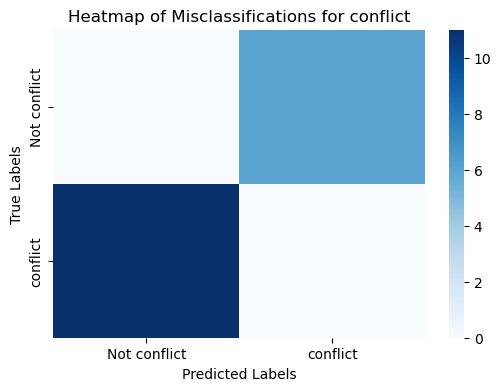

Confusion Matrix for economic consequences:
[[0 6]
 [6 0]]


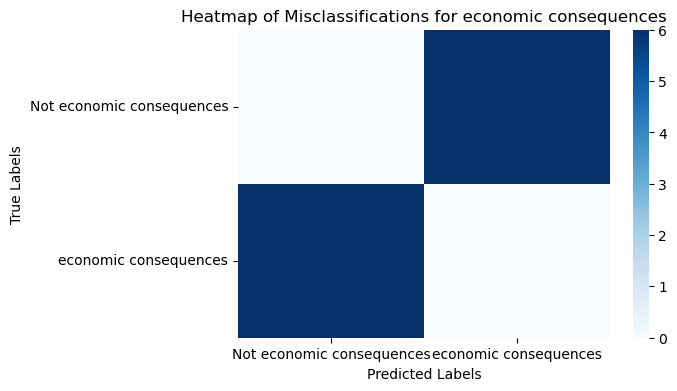

Confusion Matrix for human interest:
[[0 5]
 [4 0]]


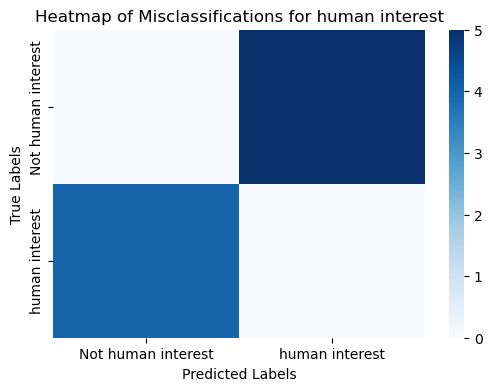

Confusion Matrix for morality:
[[0 6]
 [7 0]]


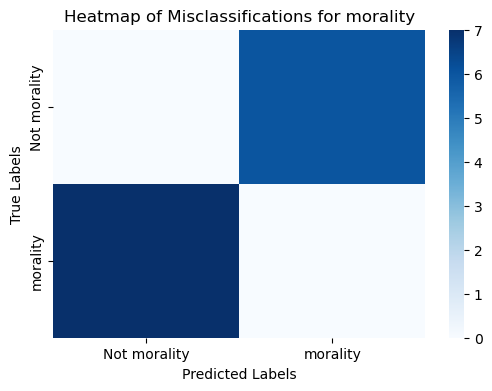

In [ ]:
category_names = ["conflict", "economic consequences", "human interest", "morality"]
plot_confusion_matrix(y_test, val_predictions, category_names)

From the heatmap, we can tell that the number of wrong classification is almost equal. This might be caused by the small amount of labeled data. In the future, the labeled dataset needs to be expanded to be more powerful.

# Prediction for the Unlabeled Data

Using the best model, we will predict the unlabeled data.

In [ ]:
unlabeled_data = pd.read_csv('unlabeled.csv')

Change the unlabeld test to list format.

In [ ]:
unlabeled_texts = unlabeled_data['Description'].tolist()

Use the best model to predict the unlabeled texts. Change the labels into list format

In [ ]:
predictions = best_model.predict(unlabeled_texts)
unlabeled_data['predicted_labels'] = predictions.tolist()

Now, the predicted labels are in one cell, with a list format. We split the predicted labels through ',', and separately put them into the four frame columns. Then the predicted labels column is deleted.

In [ ]:
if isinstance(unlabeled_data['predicted_labels'].iloc[0], str):
    unlabeled_data['predicted_labels'] = unlabeled_data['predicted_labels'].apply(lambda x: list(map(int, x.split(','))))

# Create separate columns for each label
unlabeled_data[['Conflict', 'Economic Consequences', 'Human Interest', 'Morality']] = pd.DataFrame(unlabeled_data['predicted_labels'].tolist(), index=unlabeled_data.index)

# Drop the 'predicted_labels' column as it's no longer needed
unlabeled_data = unlabeled_data.drop(columns=['predicted_labels'])

In [ ]:
# Save the updated dataset
unlabeled_data.to_csv('Predictions.csv', index=False)

Combine the labeled and unlabeled datasets together to form final.csv.

In [ ]:
file_names = [
    'video_details_shuffled_cleaned_labeled.csv',
    'Predictions.csv'
]

# Use pandas to read and concatenate all files into one DataFrame
final_df = pd.concat([pd.read_csv(f) for f in file_names], ignore_index=True)

# Save the combined DataFrame to a new CSV file
final_df.to_csv('final.csv', index=False)

print("All files have been combined into final.csv.")

All files have been combined into final.csv.


All labels have been stored in final.csv.